# covid_deaths_vs_cases

### 010822

For most of the COVID-19 pandemic, the daily focus has been on the number of cases. 

This still seems to be true as the omicron wave hits.

But omicron on the whole has been much milder. For those who are recently doubly or triple vaccinated and/or recently infected who are free from underlying comorbidities (of which the list is long), the risk of death is very small. The primary risk of this phase of the pandemic is for those not in the above groups getting sick all at once, overwhelming available beds, while the healthcare workforce is itself depleted as workers quarantine or are at home suffering (usually mild) symptoms.

I thought an interesting way to visualize differences in the various peaks would be by plotting deaths as a function of cases.

The below function, `plot_deaths_vs_cases`, does this.

It is not the prettiest, but it does the job.

Among (many) possible improvements:

- label the peaks dynamically
- make sure labels are always within axes

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from colour import Color

/Users/ramy/.pyenv/versions/3.9.2/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Data is from https://github.com/owid/covid-19-data, specifically from JHU (public > data > jhu):

In [7]:
cases  = "https://github.com/owid/covid-19-data/raw/master/public/data/jhu/biweekly_cases_per_million.csv"
deaths = "https://github.com/owid/covid-19-data/raw/master/public/data/jhu/biweekly_deaths_per_million.csv"
df_cases  = pd.read_csv(cases)
df_deaths = pd.read_csv(deaths)

In [10]:
def plot_deaths_vs_cases(country="United States",
                        min_width = 0.5,
                        max_width = 5,
                        start = Color("black"),
                        mid = Color("slategray"),
                        end = Color("red"), 
                        text_at = (0, 125, 295, 475, -1),
                        ):
    #
    # imports
    import pandas as pd
    import numpy as np
    from matplotlib import pyplot as plt
    from colour import Color
    #
    # get data
    df = pd.DataFrame({
        "dates": df_cases['date'],
        "cases": df_cases[country],
        "deaths": df_deaths[country]
         })
    df = df.dropna()
    cases  = list(df.cases)
    deaths = list(df.deaths)
    dates = list(df.dates)
    first_date = dates[0]
    last_date = dates[-1]
    L = len(df)
    #
    # set cosmetics
    colors =  list(i.hex for i in start.range_to(mid, int(round(L/2))))
    colors += list(i.hex for i in mid.range_to(end, int(round(L/2))))
    alphas = [i/L for i in range(L)]
    widths = [(max_width-min_width)*(i/L)+min_width for i in range(L)]
    #
    # create figure
    plt.figure(figsize=(5,5))
    for i in range(L-1):
        plt.plot(cases[i:i+2], deaths[i:i+2], c=colors[i], linewidth=widths[i]) #, alpha=alphas[i])
    #
    # some text
    for i in text_at:
        plt.text(cases[i], deaths[i], dates[i], color=colors[i])
    #
    # apply cosmetics    
    plt.xlabel("Biweekly cases per million")
    plt.ylabel("Biweekly deaths per million")
    plt.tight_layout()
    plt.title(f"{country} Deaths vs. Cases,\n{first_date} to {last_date}")
    plt.tight_layout()
    plt.show()
    return

Let's look at some examples.

## South Africa

South Africa had one of the earliest omicron waves.

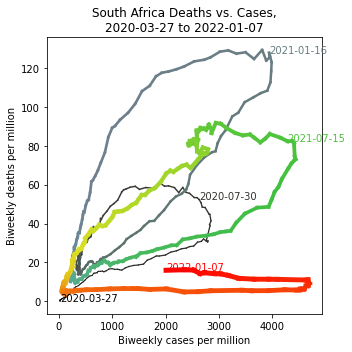

In [11]:
plot_deaths_vs_cases("South Africa")

Note the loops. Cases rise, then deaths rise, then cases fall, and finally deaths fall.

The shape and area of each loop indicates the lag time between getting sick and dying, and also the deadliness of each variant.

The alpha, beta, delta, and omicron waves are clearly visible.

## United States

Testing (and therefore the number of cases) has remained difficult to get and deaths have remained stubbornly high in the United States.

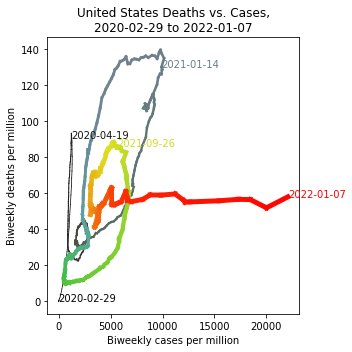

In [12]:
plot_deaths_vs_cases("United States", text_at=(0, 50, 320, 575, -1))

The omicron wave looks quite different.